# Remote Sensing Coordinate Reference Systems

Image projections can be transformed in rioxarray using the `rio.reproject()` method. The CRS is transformed using [rasterio CRS](https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html) and [virtual warping](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html). For references, see [Spatial Reference](https://spatialreference.org/) and [epsg.io](http://epsg.io/).

## View Image Coordinate Reference System & Properties
In the following we will print out the properties relevant to CRS for the red, green blue image. The CRS can be accessed from the rioxarray DataArray attributes.

In [1]:
import rioxarray as rxr

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

src = rxr.open_rasterio(image_path)
print(src.rio.transform())
print(src.rio.transform())
print(src.rio.crs)
print("nearest")  # rioxarray uses nearest by default
print(src.rio.resolution())
print(abs(src.rio.resolution()[0]), abs(src.rio.resolution()[1]))

| 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00|
| 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00|
EPSG:32621
nearest
(30.0, -30.0)
30.0 30.0


## Transforming a CRS (Reprojection)
To transform the CRS, use rioxarray's `rio.reproject()` method. In this example, a `proj4` code is used. See [understanding CRS codes](d_understand_crs_codes.html) for more details. We can pass the desired CRS as a `proj4` string, an EPSG code, or in authority:code `EPSG:4326` or `ESRI:53018`.

```{note}
Note the use of nodata in this case the file doesn't have the missing data value set in its profile, so we can set it manually when opened.
```

| 5.00, 0.00, 2502400.76|
| 0.00,-5.00,-2147313.73|
| 0.00, 0.00, 1.00|
ESRI:102008
nearest
(5.004665957048633, -5.004665957048633)


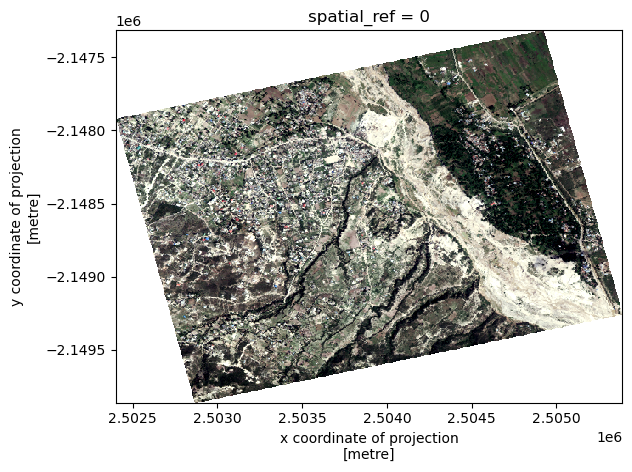

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(dpi=100)
proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

image_path = "../../pygis/data/rgbn.tif"

src = rxr.open_rasterio(image_path).rio.write_nodata(0)
# Transform CRS
src_transformed = src.rio.reproject(proj4)
# replace 0 with nan
src_transformed = src_transformed.where(src_transformed != 0, np.nan)

print(src_transformed.rio.transform())
print(src_transformed.rio.crs)
print("nearest")  # default resampling
print(src_transformed.rio.resolution())

# Plot RGB bands (adjust indices based on available bands)
if len(src_transformed.band) >= 3:
    src_transformed.isel(band=[2, 1, 0]).plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

Other formats supported by rasterio, (e.g., PROJ4 strings) can be used. Here, we use an EPSG code to transform the CRS to UTM projection.

In [3]:
image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

src = rxr.open_rasterio(image_path)
src_utm = src.rio.reproject("EPSG:32618")

print(src_utm.rio.transform())
print(src_utm.rio.crs)
print("nearest")  # default resampling
print(src_utm.rio.resolution())

| 31.61, 0.00, 2551337.44|
| 0.00,-31.61,-2933269.13|
| 0.00, 0.00, 1.00|
EPSG:32618
nearest
(31.605075990530455, -31.605075990530455)


## Resampling the Cell Size
Resampling cell size refers to the process of changing the spatial resolution of raster data. This can be done by either increasing or decreasing the size of the grid cells that make up the raster. There are different methods for resampling:

- `nearest`: Uses the value of the closest cell to assign a value to the output cell.
- `bilinear`: Uses the weighted average of the four nearest cells to determine the output cell value.
- `cubic`: Uses the weighted average of 16 nearest cells to determine the output value.

The resampling algorithm can be specified in the `rio.reproject()` function. Here, we use cubic convolution resampling to warp the data to EPSG code 31972 (a UTM projection).

In [4]:
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

src = rxr.open_rasterio(image_path)
src_transformed = src.rio.reproject("EPSG:31972", resampling=Resampling.cubic)

print(src_transformed.rio.transform())
print(src_transformed.rio.crs)
print("cubic")
print(src_transformed.rio.resolution())

| 31.61, 0.00, 2551337.44|
| 0.00,-31.61,-2933269.13|
| 0.00, 0.00, 1.00|
EPSG:31972
cubic
(31.605075990299333, -31.605075990299333)


The transformed cell resolution can be specified in the reproject method. Here, we resample the data to 10m x 10m spatial resolution.

In [5]:
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

src = rxr.open_rasterio(image_path)
src_transformed = src.rio.reproject("EPSG:31972", resolution=(10, 10), resampling=Resampling.cubic)

print(src_transformed.rio.transform())
print(src_transformed.rio.crs)
print("cubic")
print(src_transformed.rio.resolution())

| 10.00, 0.00, 2551337.44|
| 0.00,-10.00,-2933269.13|
| 0.00, 0.00, 1.00|
EPSG:31972
cubic
(10.0, -10.0)


## Transformations Outside Context Manager
To transform an xarray.DataArray outside of a configuration context, use rioxarray's `rio.reproject()` method directly.

In [6]:
from rasterio.enums import Resampling

image_path = "../../pygis/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
proj4 = "+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

src = rxr.open_rasterio(image_path)
src_tr = src.rio.reproject(proj4, resolution=(10, 10), resampling=Resampling.bilinear)

print(src_tr.rio.transform())
print(src_tr.rio.crs)
print("bilinear")
print(src_tr.rio.resolution())

| 10.00, 0.00, 5962242.52|
| 0.00,-10.00,-5200905.12|
| 0.00, 0.00, 1.00|
ESRI:102008
bilinear
(10.0, -10.0)
